In [1]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)
# skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)
# give "Not assigned" Neighborhoods same name as Borough:
df.Neighbourhood.replace("Not assigned", df.Borough, inplace=True)

# copy Borough value to Neighborhood if NaN:
df.Neighbourhood.fillna(df.Borough, inplace=True)
# drop duplicate rows:
df=df.drop_duplicates()


# extract titles from columns
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

# delete Toronto annotation from Neighbourhood:
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
df.update(
    df.Neighbourhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))
# combine multiple neighborhoods with the same post code
df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(df['Neighbourhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes
df2 = df2.rename(columns={'Postcode': 'Postal Code'})
df2.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront , Regent Park"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park (Toronto),Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,"Scarborough, Toronto","Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [3]:
print('After cleaning the DataFrame, its new shape is {}'.format(df2.shape),'\n')
print('There are:')
print('  {} Postal Codes'.format(df2['Postal Code'].unique().shape[0]))
print('  {} Boroughs'.format(df2['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(df2['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (103, 3) 

There are:
  103 Postal Codes
  11 Boroughs
  103 Neighborhoods


In [4]:
group = df2.groupby('Postal Code')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postal Code', 'Borough', 'Neighborhood']

grouped_df.head(12)

,Postal Code,Borough,Neighborhood
0,M1B,"Scarborough, Toronto","Rouge, Malvern"
1,M1C,"Scarborough, Toronto","Rouge Hill, Port Union, Highland Creek"
2,M1E,"Scarborough, Toronto","Morningside, Guildwood, West Hill"
3,M1G,"Scarborough, Toronto",Woburn
4,M1H,"Scarborough, Toronto",Cedarbrae
5,M1J,"Scarborough, Toronto",Scarborough Village
6,M1K,"Scarborough, Toronto","Kennedy Park, East Birchmount Park, Ionview"
7,M1L,"Scarborough, Toronto","Golden Mile, Clairlea, Oakridge"
8,M1M,"Scarborough, Toronto","Scarborough Village West, Cliffcrest, Cliffside"
9,M1N,"Scarborough, Toronto","Cliffside West, Birch Cliff"


In [5]:
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.set_index("Postal Code")
df2.set_index("Postal Code")
toronto_data=pd.merge(df2, dfll)
toronto_data.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront , Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,"Scarborough, Toronto","Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [6]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in toronto_data.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

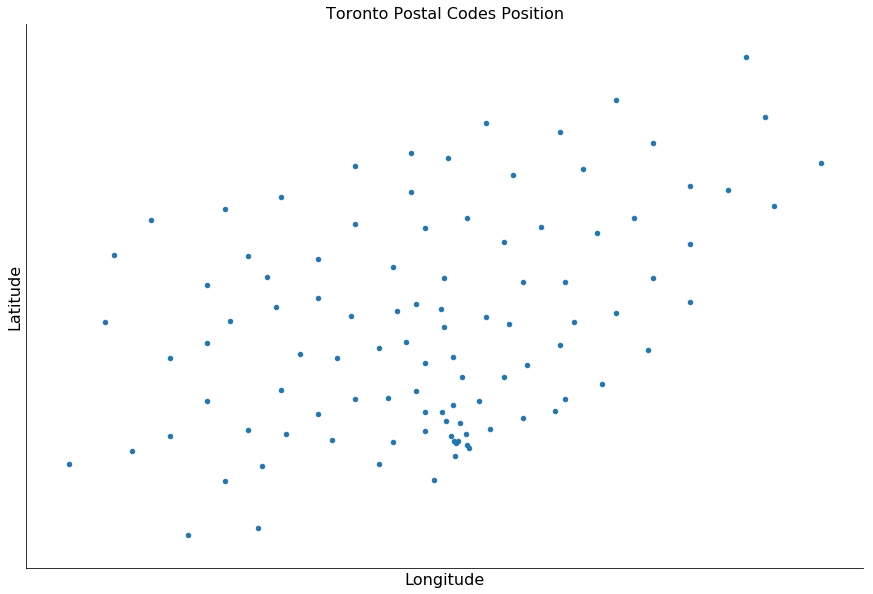

In [17]:
import matplotlib.pyplot as plt

X = toronto_data[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [18]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

In [21]:
coordinates = toronto_data[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.329656,43.753259
7,-79.352188,43.745906


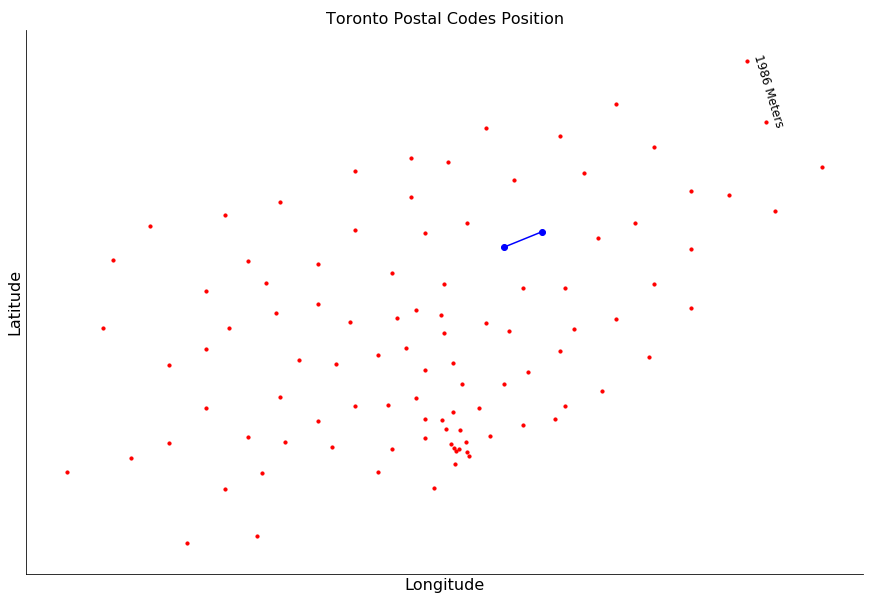

In [25]:

fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [27]:
from math import isnan

for lat, lng, idx in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    toronto_data.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
toronto_data.head(15)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Distance
0,M3A,North York,Parkwoods,43.753259,-79.329656,993.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,1018.0
2,M5A,Downtown Toronto,"Harbourfront , Regent Park",43.654260,-79.360636,614.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,934.0
4,M7A,Queen's Park (Toronto),Queen's Park,43.662301,-79.389494,256.0
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,1288.0
6,M1B,"Scarborough, Toronto","Rouge, Malvern",43.806686,-79.194353,1698.0
7,M3B,North York,Don Mills North,43.745906,-79.352188,993.0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,702.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,342.0


### Define Foursquare Credentials

In [50]:
# The code was removed by Watson Studio for sharing.

### To explore the data returned by the Foursquare API, a maximum of 100 venues from the first postcode are requested in a radius of 500 meters.

In [38]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [39]:
first_postcode = toronto_data.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=KRBOQIRZJFXTS2BGSK2CN0YYB2CGYGFA1OUN1HMDEKSZUMPP&client_secret=C1V3DPD45QVRMHUKMUGBYHSRTJE4S525EVT0AUAXC3GB40YO&ll=43.6542599,-79.3606359&v=20180605&radius=614.0&limit=100'

In [40]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [42]:
venues_df = get_venues(url)

venues_df.head(2)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'type': 'general', 'summary': 'This spot is ...",e-0-54ea41ad498e9a11e9e13308-0,"[{'id': '4bf58dd8d48988d16a941735', 'icon': {'...",54ea41ad498e9a11e9e13308,362 King St E,CA,Toronto,Canada,Trinity St,143,"[362 King St E (Trinity St), Toronto ON M5A 1K...","[{'lat': 43.653446723052674, 'lng': -79.362016...",43.653447,-79.362017,NaN,M5A 1K9,ON,Roselle Desserts,0,[],NaN
1,0,"[{'type': 'general', 'summary': 'This spot is ...",e-0-53b8466a498e83df908c3f21-1,"[{'id': '4bf58dd8d48988d1e0931735', 'icon': {'...",53b8466a498e83df908c3f21,368 King St E,CA,Toronto,Canada,at Trinity St,122,"[368 King St E (at Trinity St), Toronto ON, Ca...","[{'lat': 43.65355870959944, 'lng': -79.3618094...",43.653559,-79.361809,NaN,NaN,ON,Tandem Coffee,0,[],NaN


In [43]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head(2)

,Category,Lat,Lng,Name
0,"[{'id': '4bf58dd8d48988d16a941735', 'icon': {'...",43.653447,-79.362017,Roselle Desserts
1,"[{'id': '4bf58dd8d48988d1e0931735', 'icon': {'...",43.653559,-79.361809,Tandem Coffee


In [45]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df.head(2)

,Category,Lat,Lng,Name
0,None,43.653447,-79.362017,Roselle Desserts
1,None,43.653559,-79.361809,Tandem Coffee


In [46]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [49]:
all_venues = get_all_venues(toronto_data['Postal Code'], toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3288


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,M3A,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,M3A,43.753259,-79.329656,A&W Canada,43.760643,-79.326865,Fast Food Restaurant
4,M3A,43.753259,-79.329656,Food Basics,43.760865,-79.326015,Supermarket
5,M3A,43.753259,-79.329656,Bruno's valu-mart,43.746086,-79.324978,Grocery Store
6,M3A,43.753259,-79.329656,Shoppers Drug Mart,43.745303,-79.325249,Pharmacy
7,M3A,43.753259,-79.329656,High Street Fish & Chips,43.745260,-79.324949,Fish & Chips Shop
8,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
9,M3A,43.753259,-79.329656,Pizza Pizza,43.760231,-79.325666,Pizza Place
